# 基于PyTorch构建神经网络

主要学习内容：
- 处理CSV且转化成Tensor
- 自建神经网络模型：使用现实世界的天气数据来预测明天是否会下雨
- 使用损失函数和优化器来训练模型
- 验证模型且论证不平衡分类器模型的危险

来源：
- 文章：[Build Your First Neural Network with PyTorch](https://curiousily.com/posts/build-your-first-neural-network-with-pytorch/)
- 代码示例：[colab](https://colab.research.google.com/drive/1lDXVkdt7GC8jK_nGmOMKeDywXse-DY-u)
- 关于样本不均衡文章--[Practical Guide to Handling Imbalanced Datasets](https://curiousily.com/posts/practical-guide-to-handling-imbalanced-datasets/)

In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.27.0

numpy : 1.21.2
pandas: 1.3.1
torch : 1.8.2



In [9]:
# 下载数据
# !wget https://raw.githubusercontent.com/gchoi/Dataset/master/weatherAUS.csv
# 路径

In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from matplotlib import rc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn, optim
from tqdm import tqdm

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = [
    "#01BEFE",
    "#FFDD00",
    "#FF7D00",
    "#FF006D",
    "#93D30C",
    "#8F00FF",
]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
plt.rcParams["figure.figsize"] = 12, 8

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 数据处理

In [10]:
df = pd.read_csv("./data/weatherAUS.csv")

In [11]:
df.shape

(36881, 24)

In [12]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,5/18/2009,Hobart,5.1,14.3,0.0,1.8,8.9,NW,30.0,WSW,...,47.0,1023.1,1022.2,1.0,1.0,9.1,13.3,No,0.0,No
1,7/3/2009,Launceston,1.1,14.5,0.4,NaN,NaN,SSW,50.0,E,...,46.0,1001.5,1002.4,NaN,NaN,1.3,13.7,No,0.0,No
2,2/18/2010,Williamtown,19.7,26.2,0.0,7.2,7.2,SSE,41.0,SSE,...,50.0,1020.9,1021.9,6.0,4.0,22.7,24.4,No,0.2,No
3,3/4/2010,PerthAirport,16.6,28.0,0.0,9.0,11.3,SW,54.0,SSE,...,41.0,1018.3,1014.9,6.0,1.0,20.0,26.1,No,0.0,No
4,9/9/2010,GoldCoast,14.6,25.3,0.0,NaN,NaN,NNW,43.0,WNW,...,67.0,1020.3,1015.0,NaN,NaN,22.2,22.6,No,0.4,No


In [13]:
cols = ["Rainfall", "Humidity3pm", "Pressure9am", "RainToday", "RainTomorrow"]
df = df[cols]

In [14]:
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.0,47.0,1023.1,No,No
1,0.4,46.0,1001.5,No,No
2,0.0,50.0,1020.9,No,No
3,0.0,41.0,1018.3,No,No
4,0.0,67.0,1020.3,No,No


In [15]:
df["RainToday"].replace({"No": 0, "Yes": 1}, inplace=True)
df["RainTomorrow"].replace({"No": 0, "Yes": 1}, inplace=True)

/home/howie/anaconda3/envs/gpu_env38/lib/python3.8/site-packages/pandas/core/generic.py:6610: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [16]:
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.0,47.0,1023.1,0.0,0.0
1,0.4,46.0,1001.5,0.0,0.0
2,0.0,50.0,1020.9,0.0,0.0
3,0.0,41.0,1018.3,0.0,0.0
4,0.0,67.0,1020.3,0.0,0.0


In [17]:
# 直接删除空值行
df = df.dropna(how="any")

/home/howie/anaconda3/envs/gpu_env38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

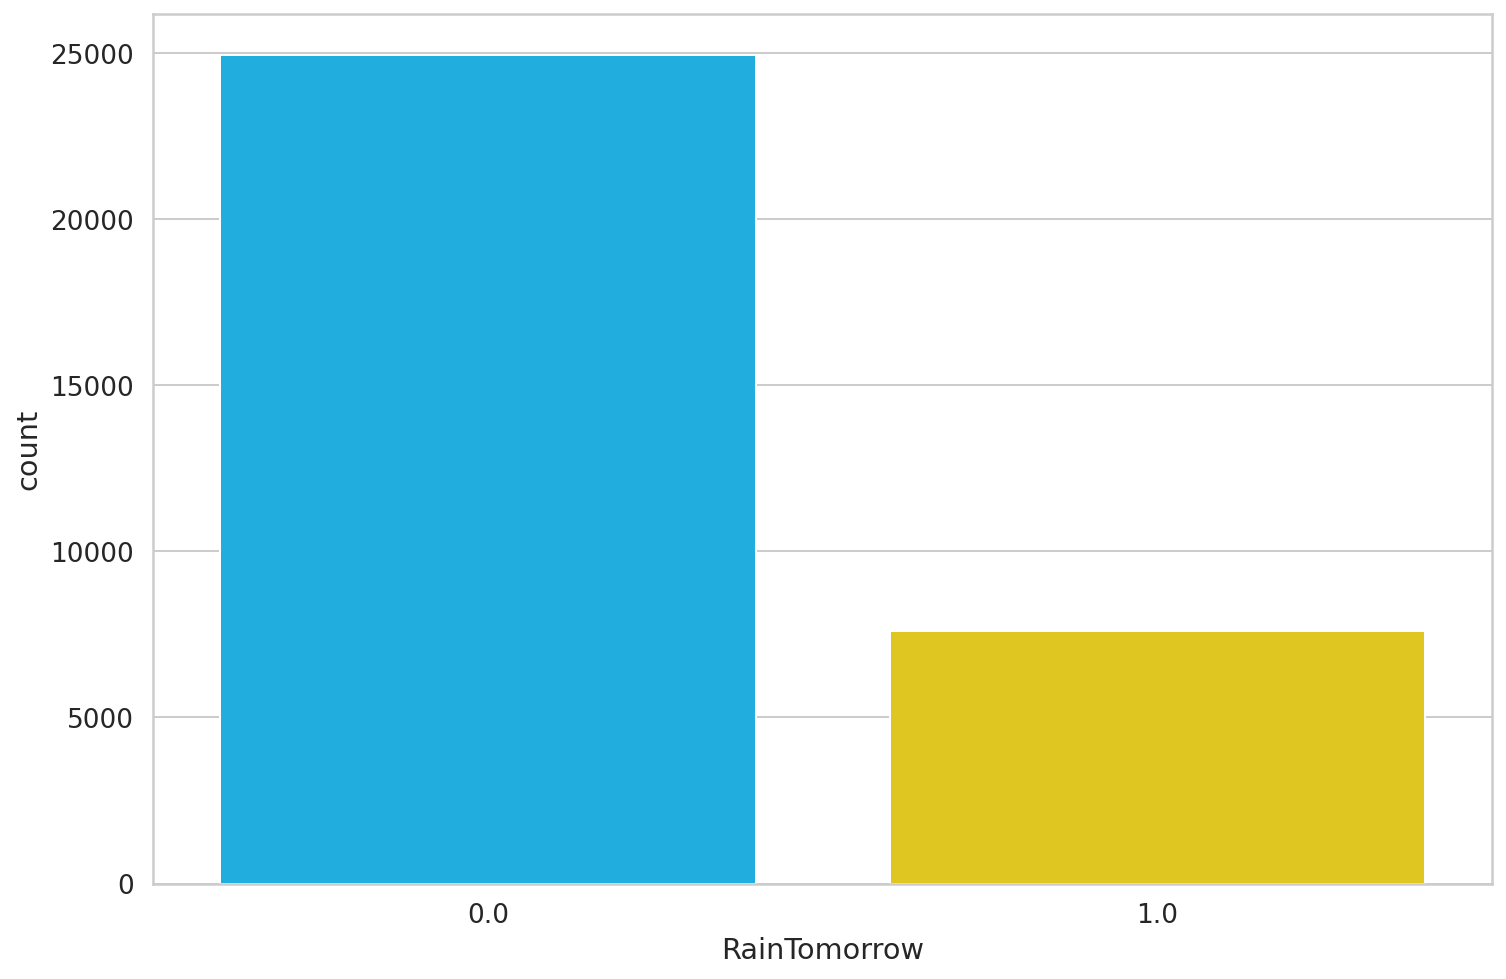

In [18]:
sns.countplot(df.RainTomorrow)

In [19]:
df.shape

(32545, 5)

In [21]:
df.RainTomorrow.value_counts() / df.shape[0]

0.0    0.766108
1.0    0.233892
Name: RainTomorrow, dtype: float64

In [43]:
# 选取样本
X = df[["Rainfall", "Humidity3pm", "RainToday", "Pressure9am"]]
y = df[["RainTomorrow"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

In [44]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

In [45]:
X_train.shape, y_train.shape

(torch.Size([26036, 4]), torch.Size([26036]))

In [46]:
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [47]:
X_test.shape, y_test.shape

(torch.Size([6509, 4]), torch.Size([6509]))

## 构建网络

In [48]:
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 5)
        self.fc2 = nn.Linear(5, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [49]:
net = Net(X_train.shape[1])

In [50]:
net

Net(
  (fc1): Linear(in_features=4, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)

In [54]:
# 二分类的交叉熵作为损失函数
criterion = nn.BCELoss()
# 优化器
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [57]:
# 传送数据到GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [61]:
net = net.to(device)
criterion = criterion.to(device)

In [62]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(0.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

## 模型训练

In [68]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)


for epoch in range(1000):
    y_pred = net(X_train)
    # 降维
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)

    # 每一百次校验一次模型效果
    if epoch % 100 == 0:
        train_acc = calculate_accuracy(y_train, y_pred)

        y_test_pred = net(X_test)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred, y_test)
        test_acc = calculate_accuracy(y_test, y_test_pred)
        print(
            f"""epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
"""
        )

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
Train set - loss: 2.656, accuracy: 0.766
Test  set - loss: 2.672, accuracy: 0.765

epoch 100
Train set - loss: 0.467, accuracy: 0.784
Test  set - loss: 0.472, accuracy: 0.782

epoch 200
Train set - loss: 0.444, accuracy: 0.794
Test  set - loss: 0.449, accuracy: 0.789

epoch 300
Train set - loss: 0.429, accuracy: 0.812
Test  set - loss: 0.435, accuracy: 0.807

epoch 400
Train set - loss: 0.42, accuracy: 0.82
Test  set - loss: 0.426, accuracy: 0.817

epoch 500
Train set - loss: 0.415, accuracy: 0.828
Test  set - loss: 0.421, accuracy: 0.822

epoch 600
Train set - loss: 0.413, accuracy: 0.829
Test  set - loss: 0.418, accuracy: 0.827

epoch 700
Train set - loss: 0.411, accuracy: 0.829
Test  set - loss: 0.417, accuracy: 0.827

epoch 800
Train set - loss: 0.41, accuracy: 0.83
Test  set - loss: 0.416, accuracy: 0.826

epoch 900
Train set - loss: 0.41, accuracy: 0.83
Test  set - loss: 0.416, accuracy: 0.827



In [67]:
for epoch in range(1):
    y_pred = net(X_train)
    print(y_pred)
    print(torch.squeeze(y_pred))

tensor([[8.2222e-06],
        [7.9753e-06],
        [7.2318e-06],
        ...,
        [7.3056e-06],
        [7.2978e-06],
        [8.5816e-06]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([8.2222e-06, 7.9753e-06, 7.2318e-06,  ..., 7.3056e-06, 7.2978e-06,
        8.5816e-06], device='cuda:0', grad_fn=<SqueezeBackward0>)


## 持久化模型

In [69]:
MODEL_PATH = "./data/weather.pth"
torch.save(net, MODEL_PATH)

## 加载模型

In [70]:
net = torch.load(MODEL_PATH)

In [72]:
classes = ["No rain", "Raining"]
y_pred = net(X_test)

In [73]:
y_pred

tensor([[0.3898],
        [0.0647],
        [0.1335],
        ...,
        [0.3351],
        [0.0430],
        [0.2635]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [76]:
y_pred = y_pred.ge(0.5).view(-1).cpu()
y_test = y_test.cpu()

In [77]:
# precision  精确度
# recall     召回率
# f1-score   F1分值
# support    各个标签次数
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.84      0.95      0.89      4979
     Raining       0.74      0.42      0.53      1530

    accuracy                           0.83      6509
   macro avg       0.79      0.68      0.71      6509
weighted avg       0.82      0.83      0.81      6509



In [79]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

cm

array([[4753,  226],
       [ 895,  635]])

In [80]:
df_cm

,No rain,Raining
No rain,4753,226
Raining,895,635


Text(0.5, 45.5, 'Predicted label')

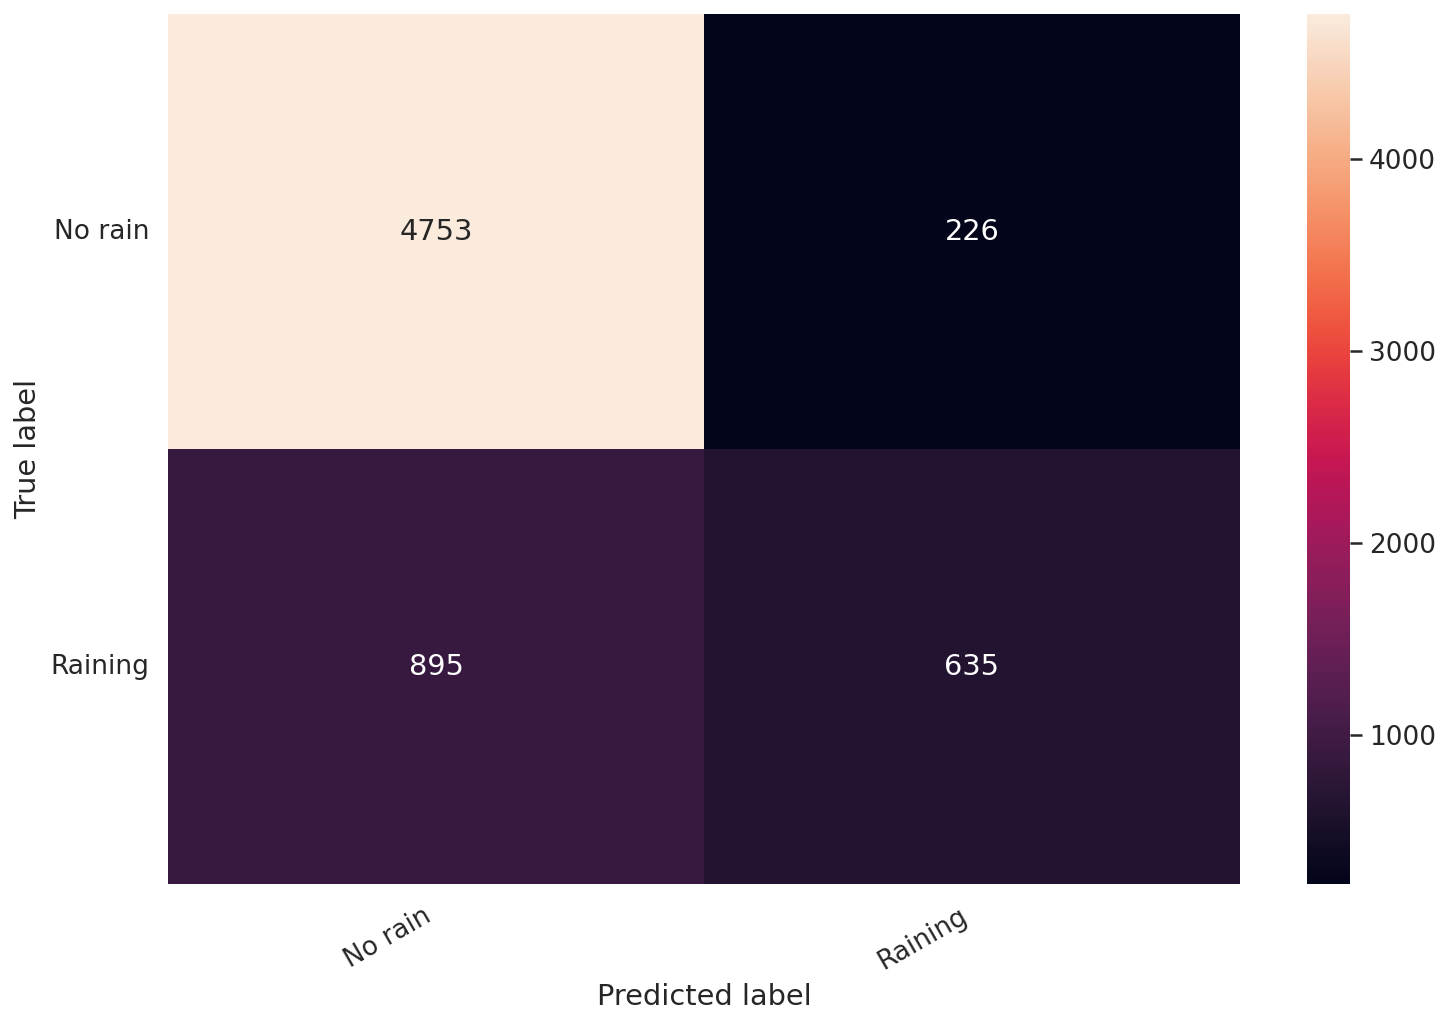

In [87]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
plt.ylabel("True label")
plt.xlabel("Predicted label")

## 预测

In [89]:
def will_it_rain(rainfall, humidity, rain_today, pressure):
    t = torch.as_tensor([rainfall, humidity, rain_today, pressure]).float().to(device)
    output = net(t)
    return output.ge(0.5).item()

In [90]:
will_it_rain(rainfall=10, humidity=10, rain_today=True, pressure=2)

True